In [63]:
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

file_path = Path('../data/fraudTrain.csv')
raw_data = pd\
    .read_csv(file_path, parse_dates=['trans_date_trans_time'])\
    .drop(columns='Unnamed: 0')
raw_data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [342]:
pd.set_option('display.max_rows', 20)
WINDOW_SIZE = 20
MAX_SAMPLES = 2979

In [338]:
def select_frauds(data: pd.DataFrame, is_fraud: int, n_sample: int = None) -> pd.DataFrame:
    '''
    selects only frauds from the data

    Args:
        data (pd.DataFrame): data to select from
        is_fraud (int): 1 if fraud, 0 if not
        n_sample (int): number of samples to select

    Returns:
        pd.DataFrame: frauds or not
    '''
    selected_ids = data[data['is_fraud'] == is_fraud]['cc_num'].unique()
    if n_sample:
        if n_sample < len(selected_ids):
            np.random.seed(20240128)
            selected_ids = np.random.choice(selected_ids, n_sample, replace=False)
    return data[data['cc_num'].isin(selected_ids)].sort_values('trans_date_trans_time')


fraud_clients = select_frauds(raw_data, 1, 300)
normal_clients = select_frauds(raw_data, 0, 1000)
print(f'{len(fraud_clients.cc_num.unique())=}')
print(f'{fraud_clients.shape=}')
print(f'{len(normal_clients.cc_num.unique())=}')
print(f'{normal_clients.shape=}')

len(fraud_clients.cc_num.unique())=300
fraud_clients.shape=(382144, 22)
len(normal_clients.cc_num.unique())=908
normal_clients.shape=(1295934, 22)


In [339]:
total_counts = fraud_clients.groupby('cc_num').size()
fraud_counts = fraud_clients[fraud_clients['is_fraud'] == 1].groupby('cc_num').size()
pd.DataFrame(
    {
        'total': total_counts,
        'fraud': fraud_counts,
        'fraud_ratio': fraud_counts / total_counts
    }
)

,total,fraud,fraud_ratio
cc_num,,,
60422928733,1531,12,0.007838
60427851591,528,14,0.026515
501831082224,1026,8,0.007797
501894933032,7,7,1.000000
501899453424,1520,8,0.005263
...,...,...,...
4798937978667559470,510,7,0.013725
4810789809665942990,1544,13,0.008420
4855853415727304322,511,12,0.023483


In [340]:
def select_fraud_windows(data: pd.DataFrame, window_size: int) -> pd.DataFrame:
    '''
    selects fraud windows from the data

    Args:
        data (pd.DataFrame): data to select from
        window_size (int): size of the window

    Returns:
        pd.DataFrame: fraud windows
    '''
    fraud_windows = []

    for name, group in tqdm(data.groupby('cc_num')):
        group = group.reset_index(drop=True)
        for idx, row in group.iterrows():
            if row['is_fraud'] == 1:
                start = max(0, idx-window_size-1)
                selected_window = group.loc[start:idx].copy()
                selected_window['window_id'] = f'{name}_{idx}'
                fraud_windows.append(selected_window)

    fraud_windows = pd.concat(fraud_windows)
    return fraud_windows

fraud_windows = select_fraud_windows(fraud_clients, WINDOW_SIZE)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:27<00:00, 10.99it/s]


In [341]:
len(fraud_windows.window_id.unique())

2979

In [343]:
def select_normal_windows(data: pd.DataFrame, window_size: int, max_samples: int) -> pd.DataFrame:
    '''
    selects normal windows from the data

    Args:
        data (pd.DataFrame): data to select from
        window_size (int): size of the window
        max_samples (int): maximum number of samples to select

    Returns:
        pd.DataFrame: normal windows
    '''
    normal_windows = []
    np.random.seed(0)  # Set the seed for reproducibility
    sample_indices = np.random.choice(data.index, size=min(max_samples, len(data)), replace=False)

    for idx in tqdm(sample_indices):
        name = data.loc[idx, 'cc_num']
        group = data[data['cc_num'] == name]
        group_idx = group.index.get_loc(idx)  # Get the index of the selected transaction in the group
        group = group.reset_index(drop=True)  # Reset the index after getting the group index
        start = max(0, group_idx - window_size)
        selected_window = group.loc[start:group_idx].copy()
        selected_window['window_id'] = f'{name}_{group_idx}'
        normal_windows.append(selected_window)

    normal_windows = pd.concat(normal_windows)
    return normal_windows

normal_windows = select_normal_windows(normal_clients, WINDOW_SIZE, MAX_SAMPLES)

100%|██████████| 2979/2979 [00:17<00:00, 166.57it/s]


In [344]:
len(normal_windows.window_id.unique())

2979

In [345]:
FEATURE_COLS = ['merchant', 'category', 'amt', 'gender', 'city', 'state', 'city_pop', 'job']
ID_COLS = ['cc_num', 'window_id']
MERCHANT_EMBEDDING_SIZE = 32
CATEGORY_EMBEDDING_SIZE = 32
JOB_TITLE_EMBEDDING_SIZE = 32

In [346]:
from gensim.models import FastText
from typing import Any, Dict
from sklearn.preprocessing import LabelEncoder


class CustomLabelEncoder(LabelEncoder):
    def transform(self, y):
        try:
            return super().transform(y) + 1
        except ValueError:
            return np.zeros(len(y), dtype=int)



def train_encoder(data: pd.DataFrame, column: str, embedding_size: int) -> FastText:
    '''
    Trains a FastText encoder on a column

    Args:
        data (pd.DataFrame): data to train on
        column (str): column to train on
        embedding_size (int): size of the embeddings

    Returns:
        FastText: trained FastText encoder
    '''
    sentences = data[column].apply(lambda x: x.split()).tolist()
    model = FastText(sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)
    return model


def transform_column(data: pd.DataFrame, column: str, encoder) -> pd.DataFrame:
    '''
    Transforms a column using an encoder

    Args:
        data (pd.DataFrame): data to transform
        column (str): column to transform
        encoder (LabelEncoder or FastText): encoder to use

    Returns:
        pd.DataFrame: data with transformed column
    '''
    data = data.copy()
    if isinstance(encoder, CustomLabelEncoder):
        data[column] = encoder.transform(data[column])
    elif isinstance(encoder, FastText):
        data[column] = data[column].apply(lambda x: encoder.wv[x])
    else:
        raise ValueError('Unsupported encoder type')
    return data


def train_label_encoder(data: pd.DataFrame, column: str) -> CustomLabelEncoder:
    '''
    Trains a LabelEncoder on a column

    Args:
        data (pd.DataFrame): data to train on
        column (str): column to train on

    Returns:
        LabelEncoder: trained LabelEncoder
    '''
    le = CustomLabelEncoder()
    le.fit(data[column])
    return le


def combine_features(data: pd.DataFrame, columns: list) -> np.ndarray:
    '''
    Combines all feature values into a single vector

    Args:
        data (pd.DataFrame): data to combine
        columns (list): list of columns to combine

    Returns:
        np.ndarray: combined feature vectors
    '''
    data = data.copy()
    data['combined'] = data.apply(lambda row: row[columns].to_list(), axis=1)
    data.combined = data.combined.apply(lambda x: flatten_list_to_array(x))
    return data
    # row[columns].tolist()


def flatten_list_to_array(lst):
    '''
    Flattens a list into a 1D array

    Args:
        lst (list): list to flatten

    Returns:
        np.ndarray: flattened 1D array
    '''
    # Convert all elements to numpy arrays and flatten them
    flattened_elements = [np.array(element).ravel() for element in lst]
    
    # Concatenate all elements into a single 1D array
    flattened_array = np.concatenate(flattened_elements)
    
    return flattened_array


def train_encoders(data: pd.DataFrame) -> Dict[str, Any]:
    '''returns a dictionary of encoder models'''

    return {
        'merchant': train_encoder(data, 'merchant', MERCHANT_EMBEDDING_SIZE),
        'category': train_encoder(data, 'category', CATEGORY_EMBEDDING_SIZE),
        'job': train_encoder(data, 'job', JOB_TITLE_EMBEDDING_SIZE),
        'gender': train_label_encoder(data, 'gender'),
        'city': train_label_encoder(data, 'city'),
        'state': train_label_encoder(data, 'state'),
    }


def encode_columns(data: pd.DataFrame, encoder_dict: Dict, feature_columns: list[str]) -> pd.DataFrame:
    '''function applies encoding transformations to the dataframe'''

    data = data.copy()
    for key, encoder in encoder_dict.items():
        data = transform_column(data, key, encoder)

    data = combine_features(data, feature_columns)
    return data


def stack_arrays(data: pd.DataFrame, id_column: str, max_rows: int, padding_value: float) -> pd.DataFrame:
    '''
    Stacks all arrays in the 'combined' column that belong to the same id into a 2D array and pads them to the same number of rows

    Args:
        data (pd.DataFrame): data to stack
        id_column (str): column to group by
        max_rows (int): number of rows to pad to
        padding_value (float): value to pad with

    Returns:
        pd.DataFrame: data with stacked and padded arrays
    '''
    unique_ids = data[id_column].unique()
    stacked_data = []
    
    for id_ in unique_ids:
        group_data = data[data[id_column] == id_]
        stacked_array = np.stack(group_data['combined'].values)
        
        # Pad the array if it has less than max_rows rows
        if stacked_array.shape[0] < max_rows:
            padding = ((0, max_rows - stacked_array.shape[0]), (0, 0))
            stacked_array = np.pad(stacked_array, padding, mode='constant', constant_values=padding_value)
        
        stacked_data.append({id_column: id_, 'combined': stacked_array})
    
    return pd.DataFrame(stacked_data)


def add_label(data: pd.DataFrame, label: int) -> pd.DataFrame:
    '''
    Adds a label to the data

    Args:
        data (pd.DataFrame): data to add label to
        label (int): label to add

    Returns:
        pd.DataFrame: data with label
    '''
    data = data.copy()
    data['label'] = label
    return data


def preprocess_data(data: pd.DataFrame, encoder_dict: dict, label: int) -> pd.DataFrame:
    '''
    Preprocesses the data

    Args:
        data (pd.DataFrame): data to preprocess

    Returns:
        pd.DataFrame: preprocessed data
    '''
    data = encode_columns(data, encoder_dict, FEATURE_COLS)
    data = stack_arrays(data, 'window_id', max_rows=WINDOW_SIZE+2, padding_value=0.0)
    data = add_label(data, label)
    return data

train_data = pd.concat(
    [
        fraud_windows[[*ID_COLS, *FEATURE_COLS]],
        normal_windows[[*ID_COLS, *FEATURE_COLS]],
    ]
)
encoder_dict = train_encoders(train_data)

In [347]:
preprocessed_frauds = preprocess_data(fraud_windows, encoder_dict, 1)
preprocessed_normal = preprocess_data(normal_windows, encoder_dict, 0)

training_data = pd.concat(
    [
        preprocessed_frauds,
        preprocessed_normal,
    ]
)

training_data.combined[20:40].apply(lambda x: x.shape)

20    (22, 101)
21    (22, 101)
22    (22, 101)
23    (22, 101)
24    (22, 101)
25    (22, 101)
26    (22, 101)
27    (22, 101)
28    (22, 101)
29    (22, 101)
30    (22, 101)
31    (22, 101)
32    (22, 101)
33    (22, 101)
34    (22, 101)
35    (22, 101)
36    (22, 101)
37    (22, 101)
38    (22, 101)
39    (22, 101)
Name: combined, dtype: object

In [348]:
def prepare_nn_input(data: pd.DataFrame, feature_column: str, label_column: str) -> tuple:
    '''
    Prepares the input for a neural network

    Args:
        data (pd.DataFrame): data to prepare
        feature_column (str): column with the features
        label_column (str): column with the labels

    Returns:
        tuple: features and labels as numpy arrays
    '''
    features = np.stack(data[feature_column].values)
    labels = data[label_column].values
    return features, labels

features, labels = prepare_nn_input(training_data, 'combined', 'label')

# Create a new neural network

In [349]:
import tensorflow as tf
from tensorflow.keras import layers

class TransformerNN(tf.keras.Model):
    def __init__(self, input_dim, embedding_dim, output_dim, num_heads, num_transformer_layers):
        super(TransformerNN, self).__init__()
        self.embedding = layers.Dense(embedding_dim)
        self.transformer_layers = [
            tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
            for _ in range(num_transformer_layers)
        ]
        self.fc = layers.Dense(output_dim)

    def call(self, x):
        x = self.embedding(x)
        x = tf.transpose(x, perm=[1, 0, 2])  # Change the dimensions to match the transformer input
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x, x)
        x = tf.transpose(x, perm=[1, 0, 2])  # Change the dimensions back to match the linear layer input
        x = self.fc(x[:, -1, :])  # Take the last output of the transformer and pass it through a linear layer
        return x

INPUT_DIM = features.shape[1]
EMBEDDING_DIM = 64
OUTPUT_DIM = 1
NUM_HEADS = 8
NUM_TRANSFORMER_LAYERS = 2

model = TransformerNN(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, NUM_HEADS, NUM_TRANSFORMER_LAYERS)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [350]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Shuffle the features and labels
features, labels = shuffle(features, labels, random_state=42)

# Split the data into training and validation sets
features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert the labels to numpy arrays
labels_train = np.array(labels_train)
labels_val = np.array(labels_val)

# Define the training parameters
batch_size = 32
epochs = 10

# Train the model
history = model.fit(features_train, labels_train, validation_data=(features_val, labels_val), batch_size=batch_size, epochs=epochs)

Epoch 1/10
149/149 [==============================] - 6s 33ms/step - loss: 7.8038 - accuracy: 0.4899 - val_loss: 7.5960 - val_accuracy: 0.5076
Epoch 2/10
149/149 [==============================] - 5s 32ms/step - loss: 7.7416 - accuracy: 0.4981 - val_loss: 7.5960 - val_accuracy: 0.5076
Epoch 3/10
149/149 [==============================] - 5s 35ms/step - loss: 7.7416 - accuracy: 0.4981 - val_loss: 7.5960 - val_accuracy: 0.5076
Epoch 4/10
149/149 [==============================] - 5s 32ms/step - loss: 7.7416 - accuracy: 0.4981 - val_loss: 7.5960 - val_accuracy: 0.5076
Epoch 5/10
149/149 [==============================] - 5s 32ms/step - loss: 7.7416 - accuracy: 0.4981 - val_loss: 7.5960 - val_accuracy: 0.5076
Epoch 6/10
149/149 [==============================] - 5s 30ms/step - loss: 7.7416 - accuracy: 0.4981 - val_loss: 7.5960 - val_accuracy: 0.5076
Epoch 7/10
149/149 [==============================] - 5s 31ms/step - loss: 7.7416 - accuracy: 0.4981 - val_loss: 7.5960 - val_accuracy: 0.5076

In [351]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta

# Define the model
model = Sequential([
    Dense(EMBEDDING_DIM, input_shape=(features.shape[1], features.shape[2]), activation='relu'),
    Dropout(.5),
    # BatchNormalization(),
    Flatten(),
    Dense(OUTPUT_DIM, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=['accuracy'],
)

# Train the model
history = model.fit(features_train, labels_train, validation_data=(features_val, labels_val), batch_size=batch_size, epochs=20)

Epoch 1/20
149/149 [==============================] - 2s 7ms/step - loss: 3218.1614 - accuracy: 0.5569 - val_loss: 135.9955 - val_accuracy: 0.7844
Epoch 2/20
149/149 [==============================] - 1s 4ms/step - loss: 3615.8750 - accuracy: 0.5690 - val_loss: 96.2853 - val_accuracy: 0.8943
Epoch 3/20
149/149 [==============================] - 1s 4ms/step - loss: 2725.9839 - accuracy: 0.6072 - val_loss: 109.9101 - val_accuracy: 0.9404
Epoch 4/20
149/149 [==============================] - 1s 4ms/step - loss: 2813.3142 - accuracy: 0.6322 - val_loss: 129.5205 - val_accuracy: 0.9539
Epoch 5/20
149/149 [==============================] - 1s 5ms/step - loss: 2557.7808 - accuracy: 0.6572 - val_loss: 100.7982 - val_accuracy: 0.9648
Epoch 6/20
149/149 [==============================] - 1s 6ms/step - loss: 2206.9944 - accuracy: 0.6614 - val_loss: 98.5528 - val_accuracy: 0.9706
Epoch 7/20
149/149 [==============================] - 1s 5ms/step - loss: 2126.0103 - accuracy: 0.6930 - val_loss: 141.0

# Test predictions

In [352]:
test_file_path = Path('../data/fraudTrain.csv')

raw_test_data = pd\
    .read_csv(test_file_path, parse_dates=['trans_date_trans_time'])\
    .drop(columns='Unnamed: 0')
raw_test_data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [353]:
test_fraud_clients = select_frauds(raw_test_data, 1, 200)
test_normal_clients = select_frauds(raw_test_data, 0, 500)
test_fraud_windows = select_fraud_windows(test_fraud_clients, WINDOW_SIZE)
test_normal_windows = select_normal_windows(test_normal_clients, WINDOW_SIZE, MAX_SAMPLES)
test_preprocessed_frauds = preprocess_data(test_fraud_windows, encoder_dict, 1)
test_preprocessed_normal = preprocess_data(test_normal_windows, encoder_dict, 0)

test_data = pd.concat(
    [
        test_preprocessed_frauds,
        test_preprocessed_normal,
    ]
)

test_data

100%|██████████| 2979/2979 [00:13<00:00, 214.47it/s]


,window_id,combined,label
0,60422928733_251,"[[-0.6738541722297668, -1.9659405946731567, 1....",1
1,60422928733_252,"[[-1.656281590461731, -1.8335574865341187, 0.8...",1
2,60422928733_253,"[[-1.8604031801223755, -1.6808956861495972, 1....",1
3,60422928733_254,"[[-1.4273927211761475, -1.6728838682174683, 0....",1
4,60422928733_255,"[[-2.019564151763916, -1.658205270767212, 0.56...",1
...,...,...,...
2974,4587657402165341815_70,"[[-2.032489776611328, -2.0514206886291504, 1.1...",0
2975,3598215285024754_1364,"[[-1.2132458686828613, -2.1514892578125, 1.452...",0
2976,3519232971341141_996,"[[-1.6748276948928833, -1.0635987520217896, 0....",0
2977,3541160328600277_1229,"[[-1.3710761070251465, -1.5567666292190552, 0....",0


In [354]:
test_features, test_labels = prepare_nn_input(test_data, 'combined', 'label')

In [355]:
test_predictions = model.predict(test_features).astype(int)
test_predictions.flatten()

156/156 [==============================] - 0s 2ms/step


array([1, 1, 1, ..., 0, 0, 0])

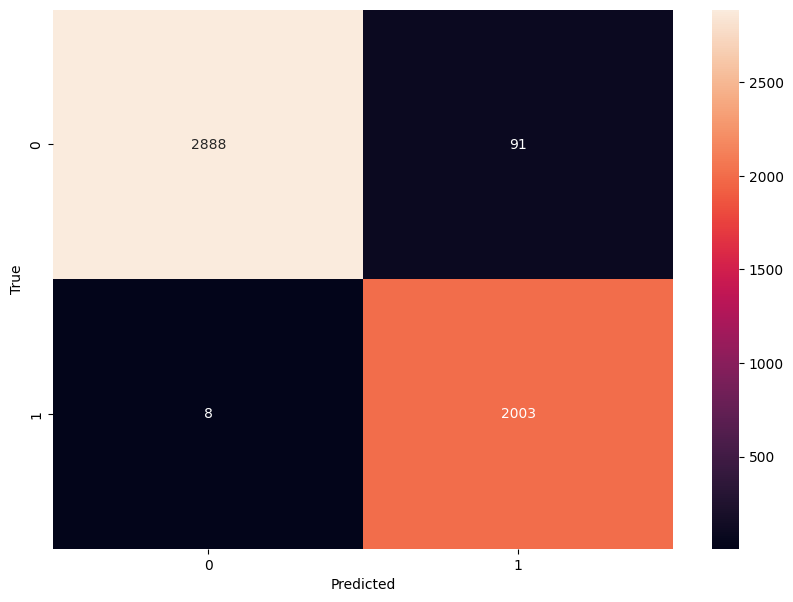

In [356]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Create the DataFrame
df = pd.DataFrame(
    {
        'label': test_labels,
        'prediction': test_predictions.flatten()
    }
)

# Calculate the confusion matrix
cm = confusion_matrix(df['label'], df['prediction'].round())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()